# Explore here

In [58]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

import pickle
from pmdarima import auto_arima
import warnings

In [59]:
warnings.filterwarnings("ignore")

In [60]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
total_data = pd.read_csv(url)
total_data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [61]:
total_data['date'] = pd.to_datetime(total_data['date'])

In [62]:
total_data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [63]:
total_data['year'] = total_data['date'].dt.year  # Año
total_data['month'] = total_data['date'].dt.month  # Mes
total_data['day'] = total_data['date'].dt.day  # Día

# Mostrar las primeras filas para verificar
print(total_data.head())

                        date      sales  year  month  day
0 2022-09-03 17:10:08.079328  55.292157  2022      9    3
1 2022-09-04 17:10:08.079328  53.803211  2022      9    4
2 2022-09-05 17:10:08.079328  58.141693  2022      9    5
3 2022-09-06 17:10:08.079328  64.530899  2022      9    6
4 2022-09-07 17:10:08.079328  66.013633  2022      9    7


In [64]:
#pd.set_option('display.max_rows', None) #Mostrar todas las filas

total_data.diff()

,date,sales,year,month,day
0,NaT,NaN,NaN,NaN,NaN
1,1 days,-1.488946,0.0,0.0,1.0
2,1 days,4.338482,0.0,0.0,1.0
3,1 days,6.389205,0.0,0.0,1.0
4,1 days,1.482734,0.0,0.0,1.0
...,...,...,...,...,...
361,1 days,0.518681,0.0,0.0,1.0
362,1 days,5.386972,0.0,0.0,1.0
363,1 days,0.827090,0.0,1.0,-30.0
364,1 days,1.535798,0.0,0.0,1.0


In [65]:

total_data['date'] = total_data['date'].dt.date  # Extraer solo la fecha (AAAA-MM-DD) de la columna 'date'
total_data = total_data.set_index('date') # Establecer la columna 'date' como índice

print(total_data.head())


                sales  year  month  day
date                                   
2022-09-03  55.292157  2022      9    3
2022-09-04  53.803211  2022      9    4
2022-09-05  58.141693  2022      9    5
2022-09-06  64.530899  2022      9    6
2022-09-07  66.013633  2022      9    7


#### - ¿Cuál es el tensor de la serie temporal?  
El tensor es la unidad mínima de tiempo para la que hay datos (día, semana, mes, etc.). En este caso hablaríamos de un día, excepto en la fila 363 en la cual hay un salto de 30 días. Un mes.

#### - ¿Cuál es la tendencia?

La tendencia es claramente creciente constante

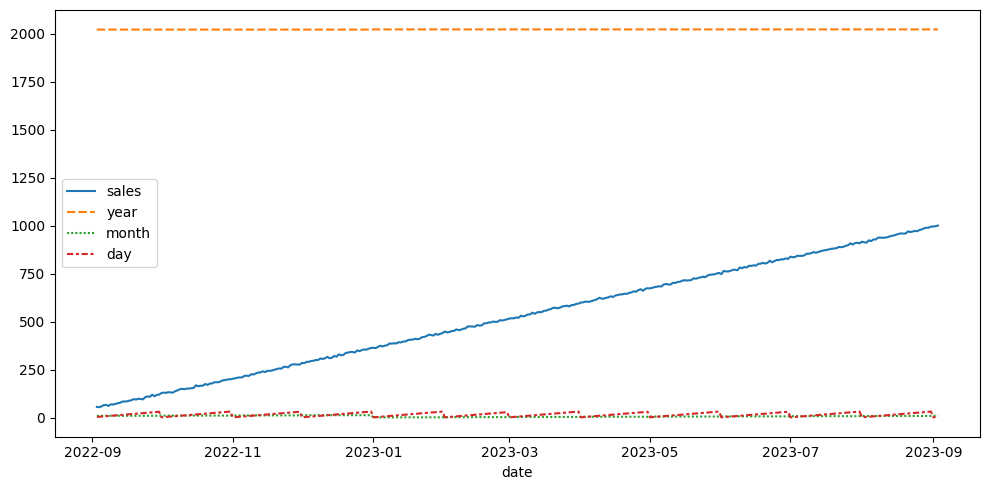

In [66]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = total_data)

plt.tight_layout()

plt.show()

#### - ¿Es estacionaria?

In [67]:
#from statsmodels.tsa.stattools import adfuller

# Prueba de Dickey-Fuller aumentada (ADF)
adf_result = adfuller(total_data['sales'])

# Extraer los resultados clave
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

# Mostrar resultados
{
    "ADF Statistic": adf_statistic,
    "p-value": p_value,
    "Critical Values": critical_values
}


{'ADF Statistic': 0.545414193706378,
 'p-value': 0.9861899815311064,
 'Critical Values': {'1%': -3.4490648539347544,
  '5%': -2.8697861692116478,
  '10%': -2.5711631253228306}}

ADF Statistic: 0.5454

Este valor es el estadístico de la prueba Dickey-Fuller.
Si este valor es más negativo que los valores críticos (como -3.449 para el 1%), rechazamos la hipótesis nula y decimos que la serie es estacionaria.
En este caso, el estadístico ADF no es más negativo que ningún valor crítico, lo que indica que la serie no es estacionaria.
p-value: 0.9862

Si el p-valor es menor a un nivel de significancia (como 0.05), rechazamos la hipótesis nula.
Aquí, el p-valor es muy alto (0.9862 > 0.05), lo que significa que no podemos rechazar la hipótesis nula y confirmamos que la serie no es estacionaria.  

Critical Values:
  
Son los valores umbrales a diferentes niveles de confianza (1%, 5%, 10%).
Si el estadístico ADF es más negativo que estos valores, la serie es estacionaria.
Aquí, el estadístico ADF (0.5454) no alcanza ninguno de estos valores, lo que refuerza que la serie no es estacionaria.

En este caso se vería que no es estacionaria claramente, la duda es si lo hacemos con muestras, ya que en la línea de gráficos si se podría ver lo estacionario.
Para ello usaremos seasonal_descompose

¿Variavilidad? 

No importante

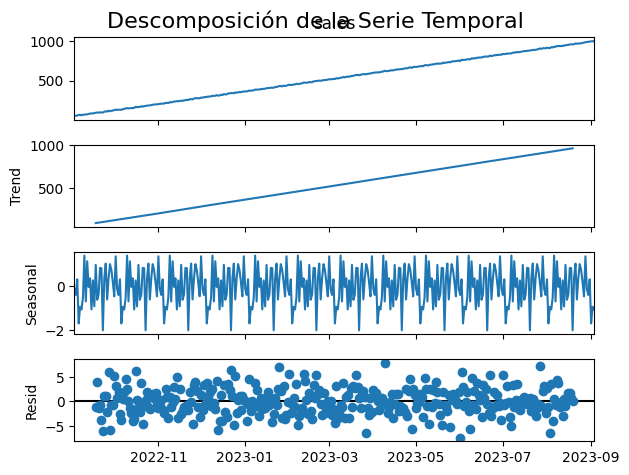

In [68]:
#from statsmodels.tsa.seasonal import seasonal_decompose
# Aplicar la descomposición estacional con un período de 30 días (asumiendo datos diarios)
decomposition_30 = seasonal_decompose(total_data['sales'], period=30, model='additive')

# Graficar 
decomposition_30.plot()
plt.suptitle('Descomposición de la Serie Temporal', fontsize=16)
plt.show()

# Extraer las componentes para análisis posterior
trend_30 = decomposition_30.trend
seasonal_30 = decomposition_30.seasonal
residual_30 = decomposition_30.resid


In [69]:
#from statsmodels.tsa.stattools import adfuller

# Prueba de Dickey-Fuller aumentada (ADF)
adf_result = adfuller(total_data['sales'])

# Extraer los resultados clave
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

# Mostrar resultados
{
    "ADF Statistic": adf_statistic,
    "p-value": p_value,
    "Critical Values": critical_values
}

{'ADF Statistic': 0.545414193706378,
 'p-value': 0.9861899815311064,
 'Critical Values': {'1%': -3.4490648539347544,
  '5%': -2.8697861692116478,
  '10%': -2.5711631253228306}}

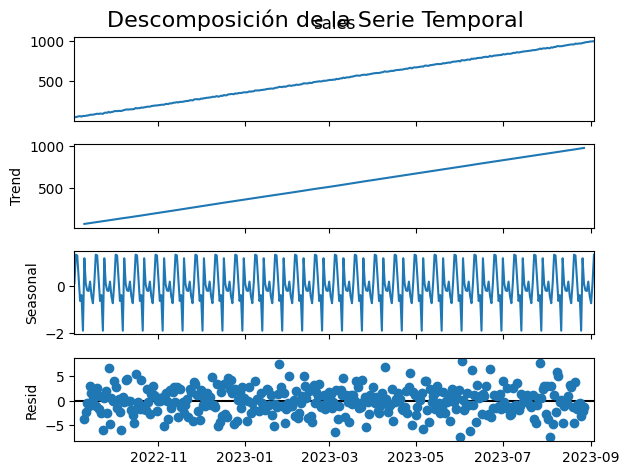

In [70]:

#from statsmodels.tsa.seasonal import seasonal_decompose
# Aplicar la descomposición estacional con un período de 14 días (asumiendo datos diarios)
decomposition_14 = seasonal_decompose(total_data['sales'], period=14, model='additive')

# Graficar 
decomposition_14.plot()
plt.suptitle('Descomposición de la Serie Temporal', fontsize=16)
plt.show()

# Extraer las componentes para análisis posterior
trend_14 = decomposition_14.trend
seasonal_14 = decomposition_14.seasonal
residual_14 = decomposition_14.resid

En este caso vemos en la linea de seasonal un claro patrón cíclico y repetitivo. Vamos a hacer el ARIMA CON AMBOS RESULTADOS:

In [71]:
# Descomposición con períodos de 30 días y 14 días
decomposition_30 = seasonal_decompose(total_data['sales'], period=30, model='additive')
decomposition_14 = seasonal_decompose(total_data['sales'], period=14, model='additive')

# Extraer componentes para el análisis
trend_30 = decomposition_30.trend.dropna()
trend_14 = decomposition_14.trend.dropna()
residuals_30 = decomposition_30.resid.dropna()
residuals_14 = decomposition_14.resid.dropna()

# Aplicar la prueba ADF para los 3 casos
# Caso 1: Datos originales
adf_result_original = adfuller(total_data['sales'])
adf_statistic_original = adf_result_original[0]
p_value_original = adf_result_original[1]
critical_values_original = adf_result_original[4]

# Caso 2:  30 días
adf_result_residuals_30 = adfuller(residuals_30)
adf_statistic_residuals_30 = adf_result_residuals_30[0]
p_value_residuals_30 = adf_result_residuals_30[1]
critical_values_residuals_30 = adf_result_residuals_30[4]

# Caso 3: 14 días
adf_result_residuals_14 = adfuller(residuals_14)
adf_statistic_residuals_14 = adf_result_residuals_14[0]
p_value_residuals_14 = adf_result_residuals_14[1]
critical_values_residuals_14 = adf_result_residuals_14[4]

# Resultados
results = {
    "Datos Originales": {"ADF Statistic": adf_statistic_original, "p-value": p_value_original, "Critical Values": critical_values_original},
    "Residuales 30 días": {"ADF Statistic": adf_statistic_residuals_30, "p-value": p_value_residuals_30, "Critical Values": critical_values_residuals_30},
    "Residuales 14 días": {"ADF Statistic": adf_statistic_residuals_14, "p-value": p_value_residuals_14, "Critical Values": critical_values_residuals_14}
}

results

{'Datos Originales': {'ADF Statistic': 0.545414193706378,
  'p-value': 0.9861899815311064,
  'Critical Values': {'1%': -3.4490648539347544,
   '5%': -2.8697861692116478,
   '10%': -2.5711631253228306}},
 'Residuales 30 días': {'ADF Statistic': -10.482643018173057,
  'p-value': 1.2025891385804124e-18,
  'Critical Values': {'1%': -3.4503224123605194,
   '5%': -2.870338478726661,
   '10%': -2.571457612488522}},
 'Residuales 14 días': {'ADF Statistic': -8.35765252642167,
  'p-value': 2.880006957967048e-13,
  'Critical Values': {'1%': -3.450081345901191,
   '5%': -2.870232621465807,
   '10%': -2.571401168202517}}}

En este caso podemos ver como claramente los datos para 14 días y 30 días si son estacionarios y perfectos para poder hacer el análisis ARIMA con ellos.   
En especial con el de 30 días, aunque trabajaremos los 3.

In [72]:
# from statsmodels.tsa.arima.model import ARIMA

# Caso 1: Datos Originales
model_original = ARIMA(total_data['sales'], order=(1, 1, 1))  # (p, d, q) = (1, 1, 1)
model_original_fit = model_original.fit()

# Caso 2: Residuales de 30 días
model_residuals_30 = ARIMA(residuals_30, order=(1, 0, 1))  # (p, d, q) = (1, 0, 1)
model_residuals_30_fit = model_residuals_30.fit()

# Caso 3: Residuales de 14 días
model_residuals_14 = ARIMA(residuals_14, order=(1, 0, 1))  # (p, d, q) = (1, 0, 1)
model_residuals_14_fit = model_residuals_14.fit()

# Mostrar resúmenes de los modelos
{
    "Modelo Datos Originales": model_original_fit.summary(),
    "Modelo Residuales 30 días": model_residuals_30_fit.summary(),
    "Modelo Residuales 14 días": model_residuals_14_fit.summary()
}

{'Modelo Datos Originales': <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                  sales   No. Observations:                  366
 Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1049.226
 Date:                Thu, 12 Dec 2024   AIC                           2104.451
 Time:                        20:21:16   BIC                           2116.151
 Sample:                    09-03-2022   HQIC                          2109.101
                          - 09-03-2023                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ar.L1          1.0000      0.000   5870.229      0.000       1.000       1.000
 ma.L1         -0.9997      0.185     -5.41

Sin diferenciación (d = 0):  

- Los datos se usan tal como están.  
Es adecuado si la serie ya es estacionaria (como los residuales).  

- Con diferenciación (d = 1):  
   
Restamos cada valor con el anterior.  
Ideal si los datos tienen tendencia (como los datos originales).  
  
- Predicción:

ARIMA predice un punto futuro en función de las combinaciones de p, d, y q.
Los parámetros afectan qué información histórica o errores pasados se usan para la predicción.

**Métricas clave:  
-AIC (Akaike Information Criterion) y BIC (Bayesian Information Criterion): Valores más bajos indican un mejor ajuste del modelo.  
-Ljung-Box: Evalúa si los residuales son ruido blanco (aleatorios). Si Prob(Q) es alto (> 0.05), los residuales no tienen patrones.  

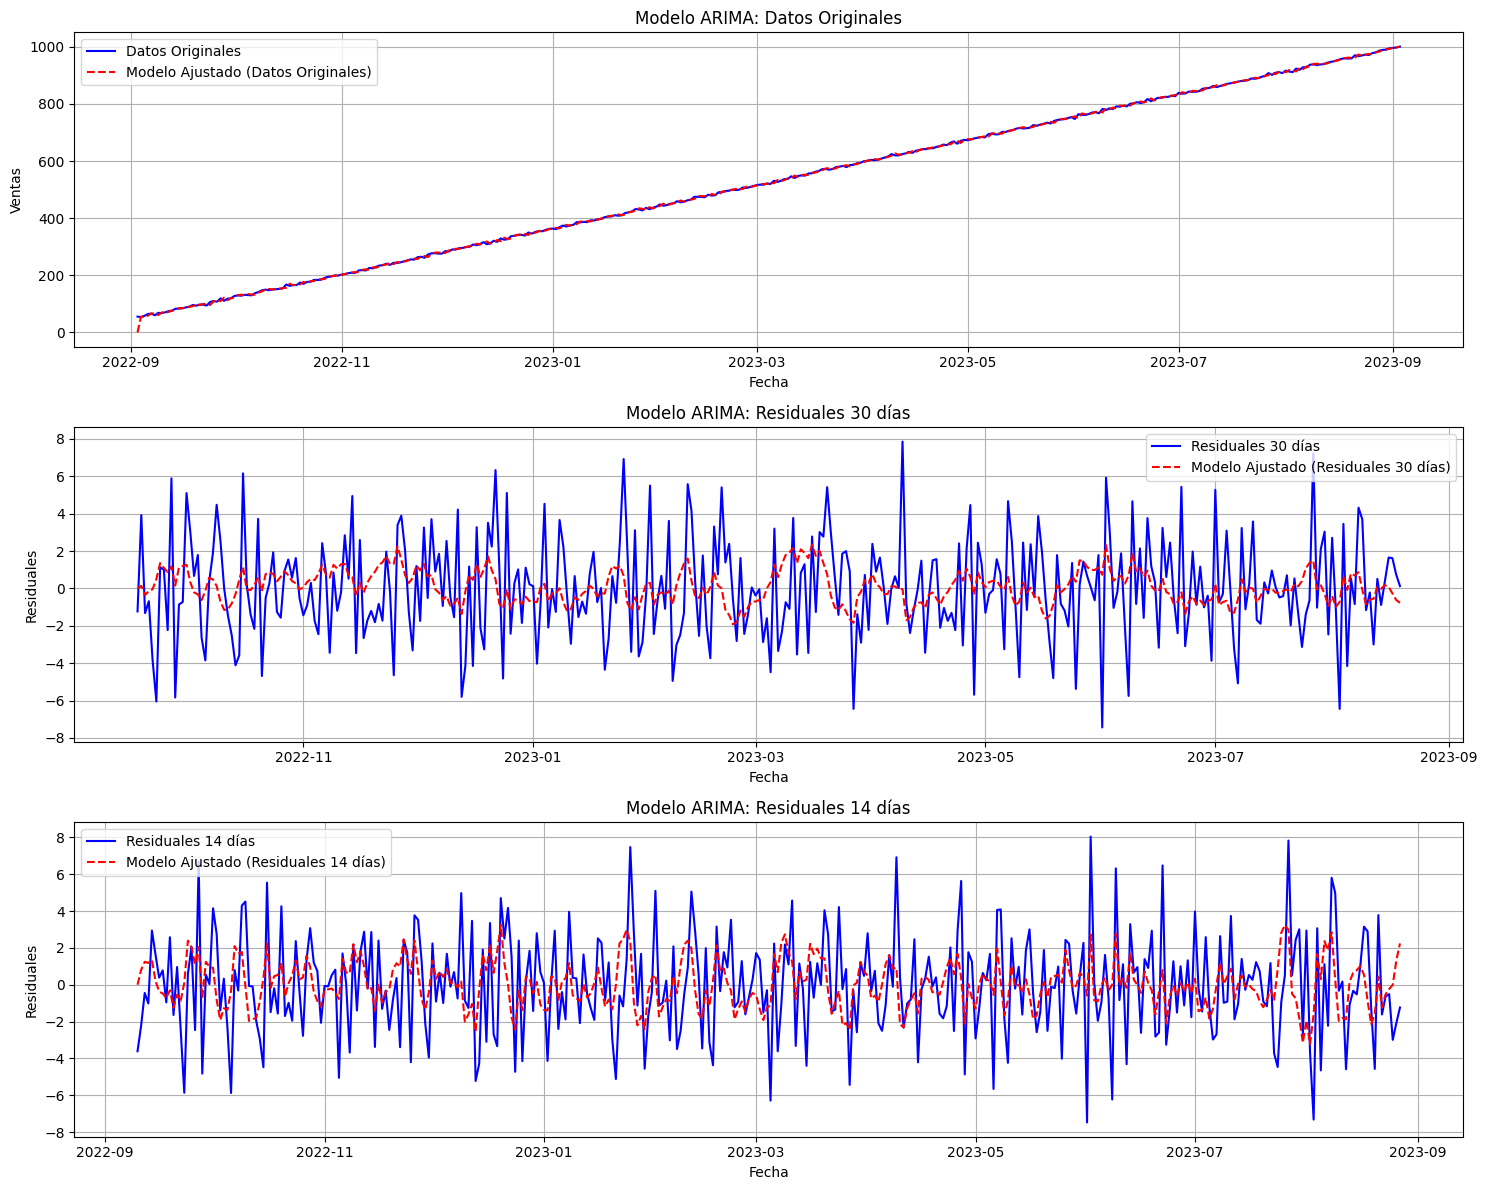

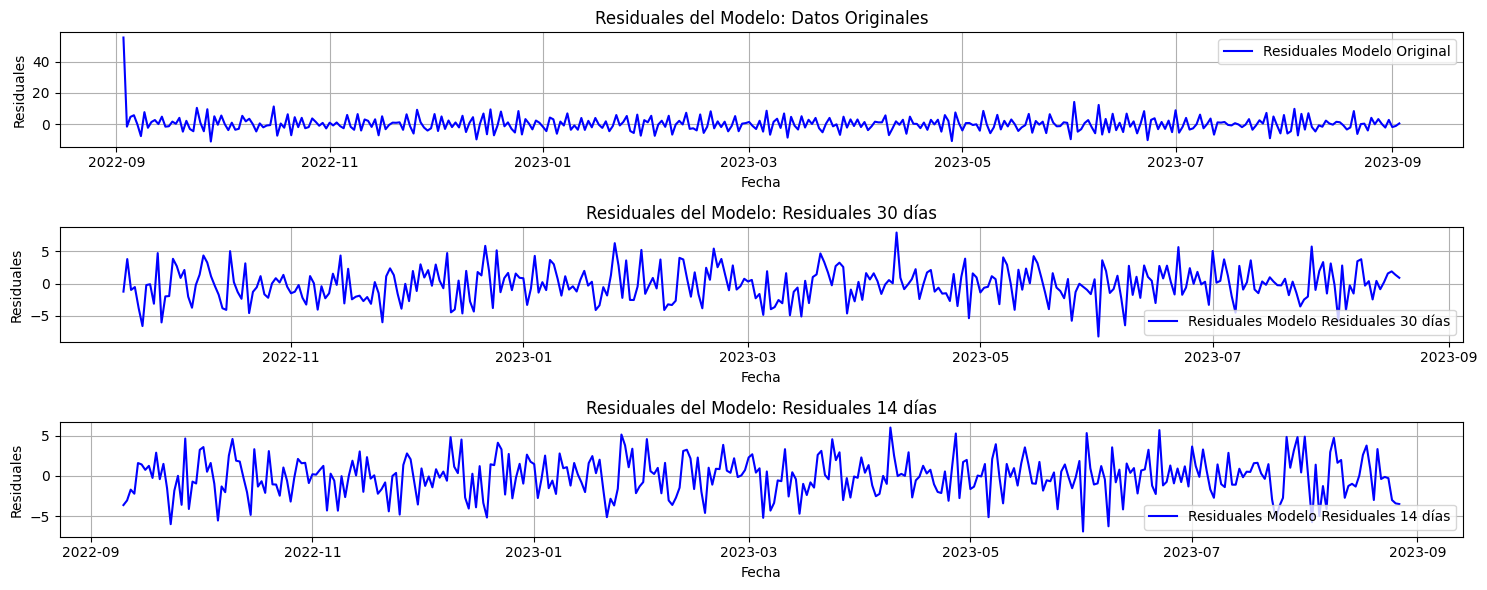

In [ ]:
fitted_original = model_original_fit.fittedvalues # Para Datos Originales
fitted_residuals_30 = model_residuals_30_fit.fittedvalues # Para Residuales de 30 días
fitted_residuals_14 = model_residuals_14_fit.fittedvalues # Para Residuales de 14 días

plt.figure(figsize=(15, 12))

# Gráfico 1: Datos Originales
plt.subplot(3, 1, 1)
plt.plot(total_data['sales'], label='Datos Originales', color='blue')
plt.plot(fitted_original, label='Modelo Ajustado (Datos Originales)', color='red', linestyle='--')
plt.title('Modelo ARIMA: Datos Originales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)

# Gráfico 2: Residuales 30 días
plt.subplot(3, 1, 2)
plt.plot(residuals_30, label='Residuales 30 días', color='blue')
plt.plot(fitted_residuals_30, label='Modelo Ajustado (Residuales 30 días)', color='red', linestyle='--')
plt.title('Modelo ARIMA: Residuales 30 días')
plt.xlabel('Fecha')
plt.ylabel('Residuales')
plt.legend()
plt.grid(True)

# Gráfico 3: Residuales 14 días
plt.subplot(3, 1, 3)
plt.plot(residuals_14, label='Residuales 14 días', color='blue')
plt.plot(fitted_residuals_14, label='Modelo Ajustado (Residuales 14 días)', color='red', linestyle='--')
plt.title('Modelo ARIMA: Residuales 14 días')
plt.xlabel('Fecha')
plt.ylabel('Residuales')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))

# Residuales del Modelo Original
plt.subplot(3, 1, 1)
plt.plot(model_original_fit.resid, label='Residuales Modelo Original', color='blue')
plt.title('Residuales del Modelo: Datos Originales')
plt.xlabel('Fecha')
plt.ylabel('Residuales')
plt.legend()
plt.grid(True)

# Residuales del Modelo Residuales 30 días
plt.subplot(3, 1, 2)
plt.plot(model_residuals_30_fit.resid, label='Residuales Modelo Residuales 30 días', color='blue')
plt.title('Residuales del Modelo: Residuales 30 días')
plt.xlabel('Fecha')
plt.ylabel('Residuales')
plt.legend()
plt.grid(True)

# Residuales del Modelo Residuales 14 días
plt.subplot(3, 1, 3)
plt.plot(model_residuals_14_fit.resid, label='Residuales Modelo Residuales 14 días', color='blue')
plt.title('Residuales del Modelo: Residuales 14 días')
plt.xlabel('Fecha')
plt.ylabel('Residuales')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#### Conclusión.
El modelo con residuales de 30 días es el mejor, con el menor AIC y BIC, lo que indica un ajuste superior. Con una baja diferencia con el de 14 días, el cual graficado parece incluso más adecuado.
Los datos originales son los menos adecuados para el modelo debido a la tendencia no estacionaria.



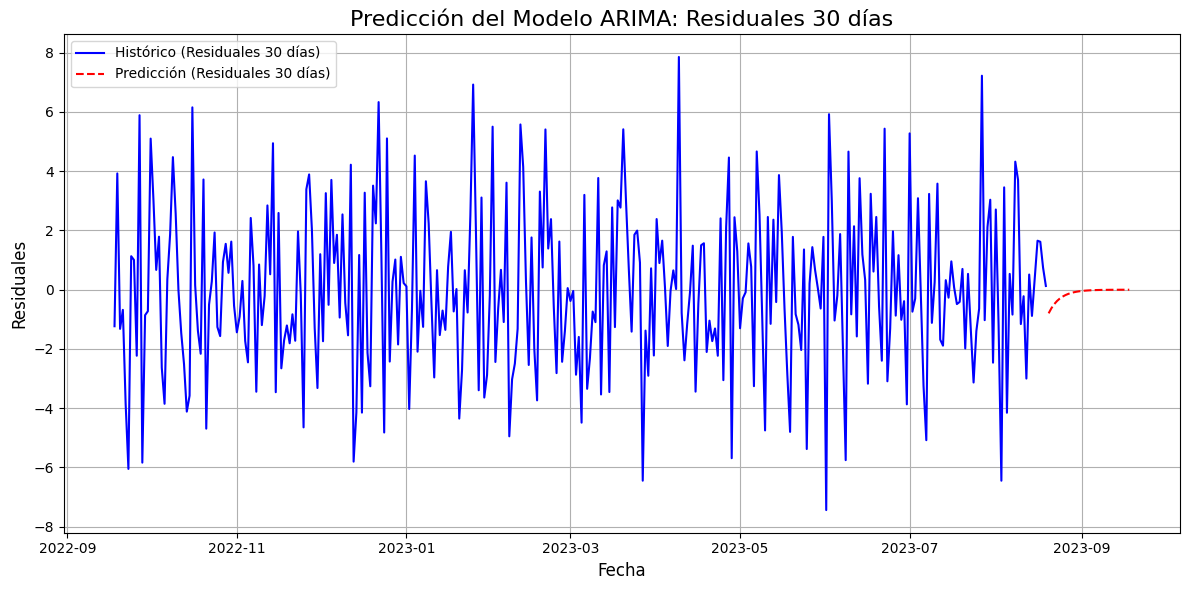

In [74]:


# Generar predicciones para el próximo mes (30 días) con el modelo de 30 días
forecast_steps = 30
forecast_residuals_30 = model_residuals_30_fit.forecast(steps=forecast_steps)

# Rango de fechas futuras para las predicciones
last_date = residuals_30.index[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, forecast_steps + 1)]

# Visualizar las predicciones junto con los datos históricos
plt.figure(figsize=(12, 6))
plt.plot(residuals_30, label='Histórico (Residuales 30 días)', color='blue')
plt.plot(future_dates, forecast_residuals_30, label='Predicción (Residuales 30 días)', color='red', linestyle='--')
plt.title('Predicción del Modelo ARIMA: Residuales 30 días', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Residuales', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [75]:
with open('arima_residuals_30.pkl', 'wb') as file:
    pickle.dump(model_residuals_30_fit, file)

# Mostrar mensaje indicando que el modelo se ha guardado
"Modelo ARIMA de Residuales 30 días guardado como 'arima_residuals_30.pkl'"

"Modelo ARIMA de Residuales 30 días guardado como 'arima_residuals_30.pkl'"